# 사전작업

## PKG_LOAD

### fasttext install guide(by.호재)
- pip install fasttext-wheel
- Microsoft C++ Build Tools 설치 필요
    - https://visualstudio.microsoft.com/ko/visual-cpp-build-tools/
- 결과 값에 대한 ISO 코드 확인은 다음 링크 참조(대부분의 결과는 ISO 639-1)
    - https://ko.wikipedia.org/wiki/ISO_639-1_%EC%BD%94%EB%93%9C_%EB%AA%A9%EB%A1%9D

In [4]:
import pandas as pd
import numpy as np
import fasttext
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

detec = fasttext.load_model('lid.176.ftz') # fasttext lenguage detection model
import warnings
warnings.filterwarnings(action='ignore')

## DATA불러오기
- 이 단계에서 사용하는 파일은 사전에 일부 전처리되었습니다(BLOCK 여부 추가,IP 관련컬럼 추가, 분석과 관련도가 낮은 컬럼들 제외)
    - COMP_INFO 컬럼의 결측치 제거
    - BLOCK_STATUS 컬럼을 추가하여 종속변수로 사용. 0 = 정상, 1 = 비정상 으로 분류
    - LAN_CHECK 컬럼을 추가하여 CATALOG_DESC의 문자열을 fasttext의 language detection 모델을 이용한 결과값을 적용

In [21]:
mem = pd.read_excel('all_member_data(drop)_final.xlsx')

In [77]:
all_mem = mem.copy()

# 전처리

In [78]:
all_mem = all_mem[['COMP_INFO','M_DIV']].dropna()

In [79]:
# plot 사용을 위해  0 = 정상, 1 = 비정상 으로 수정 (AdNormal 은 이전 작업자의 오타)
all_mem['M_DIV'] = all_mem['M_DIV'].apply(lambda x: 1 if x == 'AdNormal' else 0)

In [80]:
all_mem.rename(columns={'M_DIV':'BLOCK_STATUS'}, inplace=True)

## 공백기준의 단어형태와 escape 사용 제거
- 이 단계에서 숫자 사용은 전처리에서 제외되었으며 숫자제거 전 정확도 0.91, 숫자제거 후 정확도 0.92 로 0.01 정도의 차이를 보입니다.
    - 1. 비정상 이용자의 동일한 whatsapp 번호 사용으로 인한 차이로 추측됩니다. 
    - 2. 100% 등의 표현을 사용한 다수의 데이터가 비정상으로 분류되었기 때문으로 추측됩니다.
    
따라서, 이 데이터에서는 숫자 전처리를 진행하지 않았습니다.

In [81]:
all_mem['COMP_INFO'] = all_mem['COMP_INFO'].str.replace(r'[^\w\s]', ' ', regex=True)
# all_mem['COMP_INFO'] = all_mem['COMP_INFO'].str.replace(r'[0-9]', ' ', regex=True)
all_mem['COMP_INFO'] = all_mem['COMP_INFO'].str.replace('\n',' ')
all_mem['COMP_INFO'] = all_mem['COMP_INFO'].str.lower()
all_mem.reset_index(drop=True, inplace=True)

## fasttext language detection model 사용
해당 모델은 완벽하게 language detection 을 수행하지는 못합니다. 여기서 사용되는 데이터를 api로 이용하는 것에 대한 한계점이 존재하기 때문에 대안용으로 사용되었습니다.

- 일부 외래어로 인해 언어 분류가 잘못되는 문제가 발생합니다.
    - Fasttext 의 language detection model 을 활용하여 1차적인 분류를 하였으나, 이 모델은 완벽히 언어를 분류해내지는 못합니다.
    - 이는 ferrero, nutella, nvidia, la roche posay 등의 단어로 인해 it(이탈리아)어, fr(프랑스어)로 인식하기 때문이라 추측됩니다.
- escape 문자가 존재하면 분류를 수행하지 못합니다. 실행 전 escape 문자를 제거해주세요.

In [82]:
all_mem['LAN_CHECK'] = np.nan

for i in range(0,len(all_mem)):
    result = detec.predict(all_mem['COMP_INFO'][i], k=1)
    all_mem['LAN_CHECK'][i] = result[0][0][9:]

In [83]:
all_mem[all_mem['LAN_CHECK'] == 'ja'] # 10건
all_mem[all_mem['LAN_CHECK'] == 'zh'] # 192건

,COMP_INFO,BLOCK_STATUS,LAN_CHECK
186,新沂市东升化工有限公司 专业从事医药中间体 农药中间体和香料中间体等精细化工产品的研发 生产...,0,zh
429,meiqianmeishili 公司刚起步 嘻嘻嘻嘻嘻嘻嘻嘻寻寻寻寻寻寻寻寻寻寻寻寻寻寻寻寻...,0,zh
759,河南华探检测技术有限公司由郑州和为佳科技有限公司于2016年投资成立 位于郑州高新区企业加速...,0,zh
2103,主要经营各种网的出口工作 例如建筑安全网 水产养殖网 运动网等 我们有丰富的生产经验 所以生...,0,zh
2607,重庆水蓝科技发展有限公司 chongqing mobimax technology co ...,0,zh
...,...,...,...
188011,广州市品领进出口有限公司成立于2022 04 24 法定代表人为郑春雪 注册资本为50万元人...,1,zh
188014,巴东国际专业代理出口20年 服务外贸企业4999 1次代理 全程无忧 点击咨询报关 物流 ...,1,zh
188532,河北圣成隆化工有限公司 简介 河北圣成隆化工有限公司是国内生产十二烷基苯磺酸钙 无...,1,zh
189180,公司主要生产五金系列原材料 加工生产各种彩涂板 彩钢瓦 镀锌瓦的加工销售 国家法律规定禁止的...,1,zh


## 특정언어 제거
- 중국어와 일본어는 공백으로 구분되지 않는 특징을 가지고 있고, 기업과의 협의를 통하여 이런 특정 언어를 제외하고 모델링하기로 했습니다.

In [85]:
all_mem['LAN_CHECK'] = all_mem['LAN_CHECK'].replace('zh',np.nan)
all_mem['LAN_CHECK'] = all_mem['LAN_CHECK'].replace('ja',np.nan)
all_mem = all_mem.dropna().reset_index(drop=True)

In [128]:
all_mem.groupby('BLOCK_STATUS').describe()

COMP_INFO         \
                 count unique   
BLOCK_STATUS                    
0               100713  98531   
1                91002  29566   

                                                                       \
                                                            top  freq   
BLOCK_STATUS                                                            
0             welcome     welcome to our e catalog home  her...    59   
1             all products are 100  original new in sealed p...  3425   

             LAN_CHECK                    
                 count unique top   freq  
BLOCK_STATUS                              
0               100713     47  en  99559  
1                91002     41  en  90265

## 데이터 분리

In [86]:
X = all_mem['COMP_INFO']
Y = all_mem['BLOCK_STATUS']

In [87]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=0)

In [88]:
print(x_train.shape)
print(y_train.shape)

(134200,)
(134200,)


## STOPWORD 생성
- 영어 불용어와 관련된 단어모음인 nltk 의 stopwords 를 사용하였습니다.
- 사전에 추출한 정상/비정상 데이터의 COMP_INFO 단어 상위 100개의 중복값을 추출하여 duplication 으로 지정하였습니다.
    - duplication 을 stopword 로 지정할 경우 모델의 결과에 영항을 미침
    - 이 경우 duplication 을 stopword로 사용할 경우 정확도가 높아지므로 포함함

In [89]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [90]:
duplication = ['products', 'new', 'company', 'us', 'brand', 'product', 'quality', 'offer', 'contact', 'best', 'good', 'customers', 'service', 'well', 'factory', 'business', 'international', 'services', 'make', 'home', 'price', 'time', 'high', 'products', 'company', 'quality', 'customers', 'service', 'product', 'business', 'us', 'high', 'best', 'services', 'new', 'world', 'factory', 'international', 'good', 'well', 'offer', 'price', 'contact', 'brand', 'make', 'home', 'time']

In [91]:
list_stopwords = stopwords.words('english') + duplication

## COMP_INFO vectorizer
- CountVectorizer를 이용하여 token pattern 을 문자열데이터에서 3글자 이상의 단어만을 토큰화하였습니다.

In [111]:
cv = CountVectorizer(ngram_range=(1,4), min_df=5, stop_words=list_stopwords, token_pattern=r'[\w]{3,}')
x_train_count = cv.fit_transform(x_train)

In [112]:
x_train_count
cv.vocabulary_

{'sell': 194766,
 'kindly': 118070,
 'want': 234587,
 'buy': 31799,
 'deliver': 58534,
 'internationally': 114186,
 'sell kindly': 194949,
 'kindly want': 118199,
 'want buy': 234608,
 'buy deliver': 31865,
 'deliver internationally': 58647,
 'internationally sell': 114207,
 'sell kindly want': 194952,
 'kindly want buy': 118200,
 'want buy deliver': 234609,
 'buy deliver internationally': 31866,
 'deliver internationally sell': 58648,
 'internationally sell kindly': 114208,
 'sell kindly want buy': 194953,
 'kindly want buy deliver': 118201,
 'want buy deliver internationally': 234610,
 'buy deliver internationally sell': 31867,
 'deliver internationally sell kindly': 58649,
 'internationally sell kindly want': 114209,
 'name': 147587,
 'display': 65105,
 'page': 158686,
 'reputable': 185314,
 'oil': 152913,
 'gas': 94162,
 'mandate': 134581,
 'russia': 189657,
 'federation': 85115,
 'interested': 113796,
 'lift': 123679,
 '100': 571,
 'guarantee': 99852,
 'thanks': 221564,
 'reputabl

# MODEL - MultinominalNB
- 모델의 파라메터는 마지막에 실행되는 하이퍼 파라메터를 이용하여 최적의 파라메터 값을 사용하였습니다.
    - alpha: 스무딩을 뜻하며 학습 데이터에 없는 새로운 단어나 특성이 테스트 데이터에 나타날 경우, 확률이 0이 되는 것을 방지하기 위해 사용
    - fit_prior: 분류기가 클래스의 사전 확률을 학습할지 여부를 결정

In [113]:
model = MultinomialNB(alpha = 0.0001, fit_prior = True)
model.fit(x_train_count, y_train)

MultinomialNB(alpha=0.0001)

# 모델 검증/평가

In [114]:
x_test_count = cv.transform(x_test)
y_hat = model.predict(x_test_count)

## PRE TEST
- 기존의 문장 샘플링을 이용해 분류 성능을 시험하는 단계입니다. PREDICT_COMPINFO 안에서 ***반드시 문자열 형태*** 로 입력되어야 합니다

In [115]:
def PREDICT_COMPINFO(text):
    text = [text]
    tf = cv.transform(text)
    result = model.predict(tf)
    
    if result[0] == 1:
        print('Abnormal')
    elif result[0] == 0:
        print('Normal')

In [116]:
PREDICT_COMPINFO('I want buy a fentanyl') # (1) 비정상
PREDICT_COMPINFO('I want buy a X-ray equipment') # (0) 정상
PREDICT_COMPINFO(" We are a professional trading company based in USA. We focus on quality and reputation, ensuring that we provide our customers with top quality and innovative products. In addition, we use stringent quality control measures to ensure the reliability of our products. If you are interested in any of our products, please do not hesitate to contact us with your inquiries. We look forward to cooperating with clients worldwide on the basis of mutual benefit. ") # (1)비정상

Abnormal
Normal
Abnormal


### ABNORMAL TEXT PRE TEST
'비정상'으로 분류된 데이터의 일부를 샘플링하여 새로운 문장을 생성하고 테스트 합니다.

In [117]:
PREDICT_COMPINFO("Despite our best efforts, some items may arrive in less than perfect condition. However, we guarantee that any damaged goods will be promptly replaced or refunded as part of our satisfaction policy, which is valid for 100 days from the date of purchase. ")

PREDICT_COMPINFO("Our store prides itself on offering a wide range of authentic and original products, including electronics and cosmetics, available for worldwide shipment. We work closely with trusted carriers like FedEx to ensure that your order is safely packed and delivered directly to your doorstep within a reasonable time frame.")

PREDICT_COMPINFO("Wholesale items are guaranteed to arrive in their original condition and within the policy period. We take care of the shipping and handling, and if for any reason you're unhappy with your purchase, we offer free returns. ")

Abnormal
Abnormal
Abnormal


### NORMAL TEXT PRE TEST
'정상'으로 분류된 데이터의 일부를 샘플링하여 새로운 문장을 생성하고 테스트 합니다.

In [118]:
PREDICT_COMPINFO("We are committed to providing high-quality products and exceptional customer service to clients in the manufacturing industry, utilizing advanced technology and materials to meet their specific needs and requirements.")

PREDICT_COMPINFO("As a global leader in the manufacturing industry, our company is dedicated to promoting sustainable and environmentally friendly practices in all aspects of our operations, providing clients with responsible solutions that meet their needs.")

PREDICT_COMPINFO("Our company offers advanced technology solutions to meet diverse needs in the manufacturing industry, providing customized equipment and materials to clients worldwide.")

Normal
Normal
Normal


## CONFUSUION MATRIX

In [119]:
cm = confusion_matrix(y_test, y_hat)
cm

array([[29740,   474],
       [ 4037, 23264]], dtype=int64)

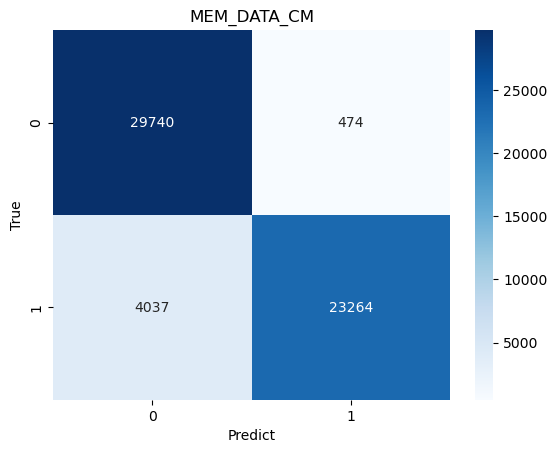

In [120]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g') # fmt = 'g' 를 이용해 정수표현
plt.title('MEM_DATA_CM')
plt.xlabel('Predict')
plt.ylabel('True')

plt.show()

## 종합평가

In [121]:
print(f'Accuracy: {accuracy_score(y_test, y_hat):.3f}')
print(f'Precision:{precision_score(y_test, y_hat):.3f}')
print(f'recall:{recall_score(y_test, y_hat):.3f}')
print(f"F1_micro: {f1_score(y_test, y_hat, average='micro'):.3f}")
print(f"F1_macro: {f1_score(y_test, y_hat, average='macro'):.3f}")
print(f"F1_weight: {f1_score(y_test, y_hat, average='weighted'):.3f}")
print(f"F1_score: {f1_score(y_test, y_hat):.3f}")
pred_proba_positive = model.predict_proba(x_test_count)[:,1]
print(f'AUC: {roc_auc_score(y_test, pred_proba_positive):.3f}')

Accuracy: 0.922
Precision:0.980
recall:0.852
F1_micro: 0.922
F1_macro: 0.921
F1_weight: 0.921
F1_score: 0.912
AUC: 0.960


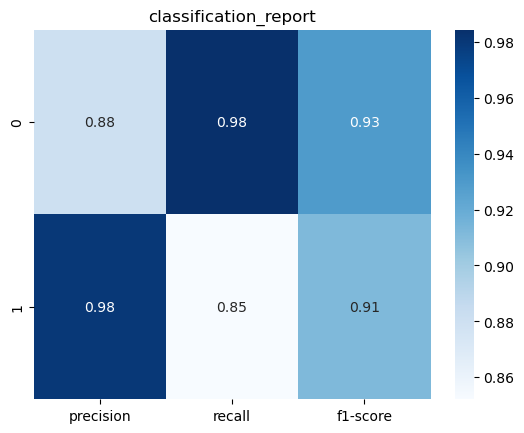

In [122]:
cr = classification_report(y_test, y_hat, output_dict='Ture')
report_df = pd.DataFrame(cr).T

sns.heatmap(report_df.iloc[:2,:-1], annot=True, cmap='Blues')
plt.title('classification_report')
plt.show()

## Threshold 조정에 따른 차이
- MultinomialNB 는 직접적으로 임계값을 수정할 수 없으므로 참고용으로만 보면 좋을 것 같습니다

In [127]:
predicted_prob = model.predict_proba(x_test_count)
threshold = 0.4 # 최고의 성능을 나타내는 임계값은 0.2 ~ 0.4
predicted = (predicted_prob[:, 1] > threshold).astype(int)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     30214
           1       0.98      0.88      0.93     27301

    accuracy                           0.94     57515
   macro avg       0.94      0.93      0.93     57515
weighted avg       0.94      0.94      0.93     57515



## ROC_AUC CURVE

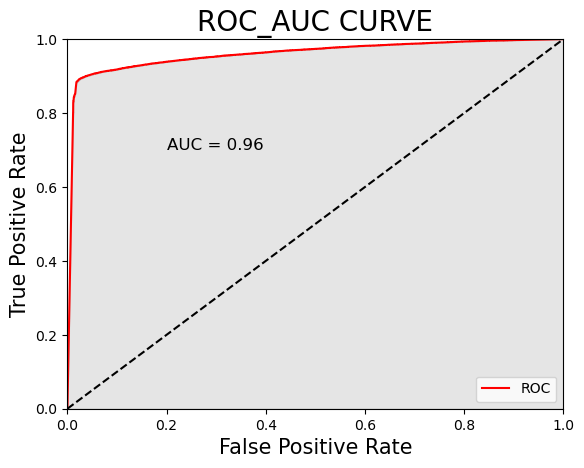

In [124]:
fpr, tpr, threshold = roc_curve(y_test, pred_proba_positive)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr, color='red', label='ROC')
plt.title('ROC_AUC CURVE', size=20)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='best')
plt.fill_between(fpr, tpr, 0, alpha=0.2, color='grey')
plt.text(0.2, 0.7, 'AUC = %0.2f' % roc_auc, fontsize=12)
plt.show()

## 평균교차검증

In [125]:
# 주의1! 이 코드를 실행 할 경우 X데이터 전체에 대해 새로운 fit_transform 을 수행하므로 많은 시간이 소요됩니다.
# 주의2! 이 코드를 실행하면 이전의 train,test 로 분리하여 검증, 평가한 값들에 영향을 미치게 됩니다. 그러므로 위에 코드들을 실행할 필요가 있다면 [2.4  COMP_INFO vectorizer] 단계부터 다시 실행하세요.

X_count = cv.fit_transform(X)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(model, X_count, Y, scoring='accuracy', cv=stratified_kfold)
print('교차 검증별 정확도: ', np.round(scores,3))
print('평균 검증 정확도: ', np.round(np.mean(scores),3))

교차 검증별 정확도:  [0.927 0.926 0.927 0.927 0.928]
평균 검증 정확도:  0.927


# 하이퍼파라메터 조합

In [126]:
# MultinomialNB 파라메터 정의
hyperparameters = {
    'alpha': np.linspace(0.0001, 1),
    'fit_prior': [True, False]
}

clf = MultinomialNB()

grid_search = GridSearchCV(clf, hyperparameters, cv=5)
grid_search.fit(x_train_count, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'alpha': 0.0001, 'fit_prior': True}
